# Marcenko pasture pdf and Random matrixes

From wikipedia: <br><i>
-In the mathematical theory of random matrices, the Marchenko–Pastur distribution, or Marchenko–Pastur law, describes the asymptotic behavior of singular values of large rectangular random matrices. The theorem is named after Ukrainian mathematicians Vladimir Marchenko and Leonid Pastur who proved this result in 1967.

If X denotes a m x n random matrix whose entries are independent identically distributed random variables with mean 0 and variance $\sigma^{2}<\infty$ , let
\begin{equation*}
Y_n = \frac{1}{m}XX^T
\end{equation*}
and let $\lambda _1,\lambda _2, .... \lambda_m$ be the eigenvalues of $Y_n$
    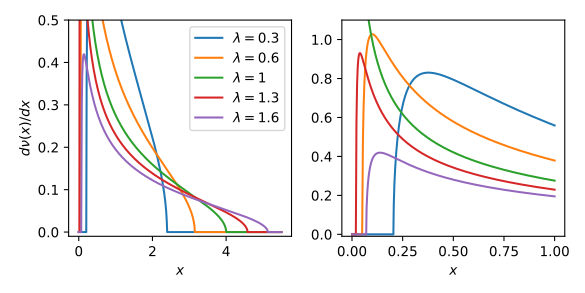
</i>

In particular for a correlation matrix - Let X be i.i.d random observations of size $TxN$ where the underlying process generating the observation has mean 0, and variance $\sigma^2$ then the correlation matrix, $C=T^-1X^TX$, has eigenvalues $\lambda$ distributed according to the Marcenko-Pastur distribution

\begin{equation*}
f(\lambda) = \frac{T}{N}\frac{\sqrt{( \lambda_+-\lambda )( \lambda_--\lambda )}}{2\pi\lambda\sigma^2}\unicode{x1D7D9}_{(\lambda_-,\lambda_+)}
\end{equation*}

where 
\begin{equation*}
\lambda_+ = \sigma^2(1+\sqrt{\frac{N}{T}})^2 \\
\lambda_- = \sigma^2(1-\sqrt{\frac{N}{T}})^2
\end{equation*}

When C is a correlation matrix, $\sigma^2=1$


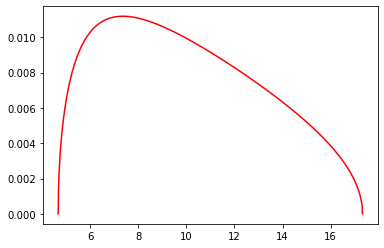

In [3]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
import matplotlib.pylab as plt
from scipy.optimize import minimize

#Marcenko-Pastur pdf
#q=T/N 
def mpPDF(var, q, pts):
    eMin, eMax = var*(1-(1./q)**.5)**2, var*(1+(1./q)**.5)**2 # calc lambda_minus, lambda_plus
    eVal = np.linspace(eMin, eMax, pts) #Return evenly spaced numbers over a specified interval. eVal='lambda'
    pdf = q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5 #np.allclose(np.flip((eMax-eVal)), (eVal-eMin))==True
    pdf = pd.Series(pdf, index=eVal)
    return pdf

N = 1000
T = 10000
pdf0 = mpPDF(1., q=N/T, pts=N)
plt.plot(pdf0.keys(), pdf0, color='r', label="Marcenko-Pastur pdf")

The Weigner eigenvalues displays universality.

1. Macroscopic scale: MP obeys the Weigner semicircle law
2. Mecoscopi scale:
3. Microscopic scale: distribtion of eigenvalues is an open problem in analysis
Terence Tao:(https://www.youtube.com/watch?v=tihxQGGrMcc)

## Correlation matrixes
\begin{equation*}
corr(X,Y) = \frac{cov(X,Y)}{\sigma_x \sigma_y}
\end{equation*}

\begin{equation*}
cov(X,Y) = E[(X-E[X])(Y-E[Y])] = \sum_{i=0}^{i=n} \frac{(X_i-\mu_x)(Y_i-\mu_y)}{n-1}
\end{equation*}
Correlation is just covariance scaled to [-1,1]

The main idea with covariance is that it can identify relationships with positive, negative and no trend.
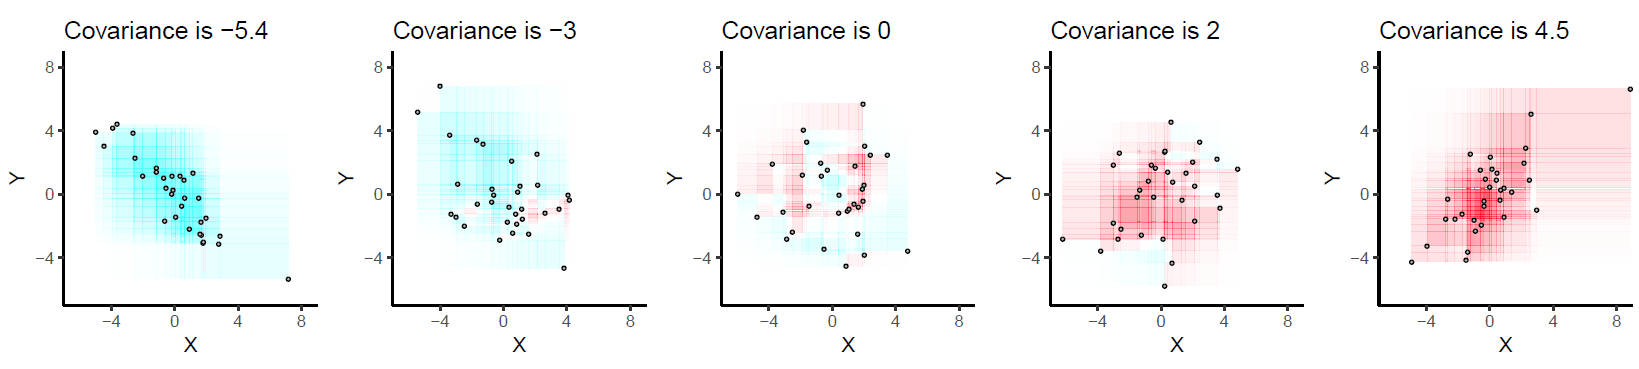

In [16]:
    N = 1000
    T = 10000
    x = np.random.normal(0, 1, size = (T, N))
    # x has 1000 indicators - one pr column - with rows=10.000 time-steps
    cor = np.corrcoef(x, rowvar=0) 

Define a function getPCA to get the eigenvalues, and eigenvectors - sorted.

In [5]:
def getPCA(matrix):
    # Get eVal, eVec from a Hermitian matrix
    eVal, eVec = np.linalg.eig(matrix) #complex Hermitian (conjugate symmetric) or a real symmetric matrix.
    indices = eVal.argsort()[::-1] #arguments for sorting eval desc
    eVal,eVec = eVal[indices],eVec[:,indices]
    eVal = np.diagflat(eVal) # identity matrix with eigenvalues as diagonal
    return eVal,eVec

Lets find the eigenvalues and plot the histogram with MP pdf.

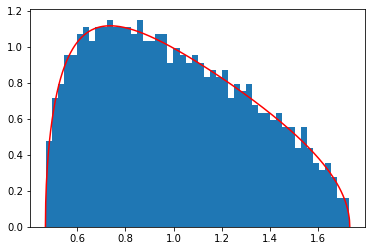

In [29]:
eVal0 , eVec0 = getPCA( cor ) 
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=N)
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.hist(np.diag(eVal0), density = True,bins=50) # Histogram the eigenvalues
plt.plot(pdf0.keys(), pdf0, color='r', label="Marcenko-Pastur pdf")
plt.show()

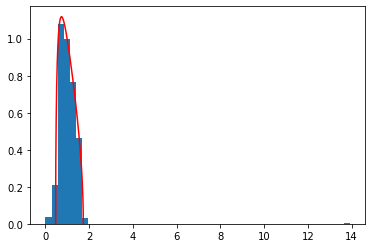

In [44]:
x = np.random.normal(0, 1, size = (T, N))

sin_np = np.sin([i for i in range(0,T)])
sin_plus_pi_fourth = sin_np + np.pi/4
cos_np = np.cos([i for i in range(0,T)])

x[:,0] = -sin_np #np.ones(T)
x[:,1] = -sin_np

for j in range(2,10):
    x[:,j] += sin_np #+
    
for j in range(11,20):
    x[:,j] = sin_plus_pi_fourth #+

cor = np.corrcoef(x, rowvar=0) 

eVal0 , eVec0 = getPCA( cor ) 
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=N)
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.hist(np.diag(eVal0), density = True,bins=50) # Histogram the eigenvalues
plt.plot(pdf0.keys(), pdf0, color='r', label="Marcenko-Pastur pdf")
plt.show()

Lets find the clusters in the correlation matrix using KMeans clustering and the silhouett method for finding the optimal numbers of clusters.

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
import seaborn as sns

#Use a silhouett method to find optimal number of clusters for KMeans clustering
def clusterKMeansBase(corr0, maxNumClusters=10, n_init=10):
    x, silh = ((1-corr0.fillna(0))/2.)**.5, pd.Series(dtype='float64') #observations matrix
    x, silh = ((1-corr0)/2.)**.5, pd.Series(dtype='float64') #observations matrix
    maxNumClusters = min(maxNumClusters, x.shape[0]-1)
    for init in range(n_init):
        for i in range(2, maxNumClusters+1):
            #print(i)
            kmeans_ = KMeans(n_clusters=i, n_init=1) #n_jobs=None, n_init=1) #n_jobs=None - use all CPUs
            kmeans_ = kmeans_.fit(x)
            silh_ = silhouette_samples(x, kmeans_.labels_)
            stat = (silh_.mean()/silh_.std(), silh.mean()/silh.std())
            if np.isnan(stat[1]) or stat[0] > stat[1]:
                silh, kmeans = silh_, kmeans_
    
    newIdx = np.argsort(kmeans.labels_)
    corr1 = corr0.iloc[newIdx] #reorder rows
    
    corr1 = corr1.iloc[:, newIdx] #reorder columns
    clstrs = {i:corr0.columns[np.where(kmeans.labels_==i)[0]].tolist() for i in np.unique(kmeans.labels_)} #cluster members
    silh = pd.Series(silh, index=x.index)
    
    return corr1, clstrs, silh

Lets apply it to the correlation matrix with signal

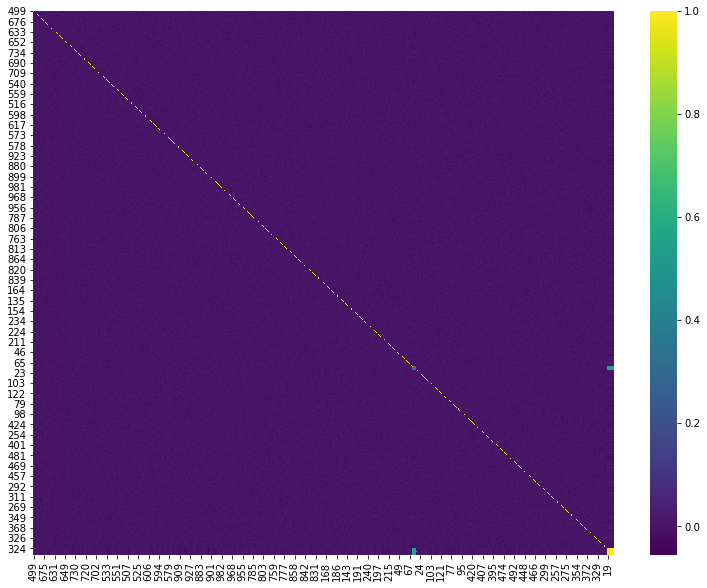

{0: [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 22

In [41]:
corr0, clstrs, silh = clusterKMeansBase(pd.DataFrame(cor), maxNumClusters=10, n_init=10)
fig, ax = plt.subplots(figsize=(13,10))  
sns.heatmap(corr0, cmap='viridis')
plt.show()
print(clstrs)

sse:743.1534494023749
sse:743.153355403545
sse:290.10782891523957
sse:290.10782484960697
sse:280.76713662913284
sse:280.7671415353009
sse:227.5385159374073
sse:227.53852372064816
sse:294.3847149888451
sse:294.3846654112964
sse:55.16772229943107
sse:55.16773351535698
sse:18.626127703694213
sse:18.626130233377488
sse:26279.570295985366
sse:26279.567083991562
sse:373.4297606257362
sse:373.42970440098526
sse:17.737014190406967
sse:17.73701461364513
sse:17.713077794784923
sse:17.713077770346317
sse:17.71299869557359
sse:17.712998695787547
sse:17.7129986896149
sse:17.712998689614945
found errPDFs0.676938807991473


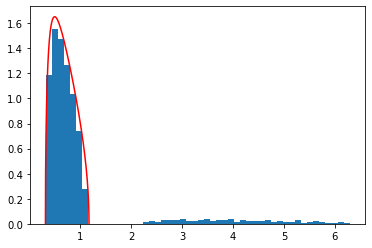

In [55]:
def getRndCov(nCols, nFacts): #nFacts - contains signal out of nCols
    w = np.random.normal(size=(nCols, nFacts))
    cov = np.dot(w, w.T) #random cov matrix, however not full rank
    cov += np.diag(np.random.uniform(size=nCols)) #full rank cov
    return cov

def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std,std)
    corr[corr<-1], corr[corr>1] = -1,1 #for numerical errors
    return corr

alpha, nCols, nFact, q = .995, 1000, 100, 10
cov = np.cov(np.random.normal(size=(nCols*q, nCols)), rowvar=0) #size = (1000*10,1000)
cov = alpha*cov+(1-alpha)*getRndCov(nCols, nFact) # noise + signal
corr0 = cov2corr(cov)
eVal01, eVec01 = getPCA(corr0)

#find the variance of the matrix with signal
#######################
from sklearn.neighbors import KernelDensity

def fitKDE(obs, bWidth=.15, kernel='gaussian', x=None):
    #Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    #print(len(obs.shape) == 1)
    if len(obs.shape) == 1: obs = obs.reshape(-1,1)
    kde = KernelDensity(kernel = kernel, bandwidth = bWidth).fit(obs)
    #print(x is None)
    if x is None: x = np.unique(obs).reshape(-1,1)
    #print(len(x.shape))
    if len(x.shape) == 1: x = x.reshape(-1,1)
    logProb = kde.score_samples(x) # log(density)
    pdf = pd.Series(np.exp(logProb), index=x.flatten())
    return pdf

# find max random eVal by fitting Marcenko's dist
# and return variance
def findMaxEval(eVal, q, bWidth):
    out = minimize(lambda *x: errPDFs(*x), x0=np.array(0.5), args=(eVal, q, bWidth), bounds=((1E-5, 1-1E-5),))
    print("found errPDFs"+str(out['x'][0]))
    if out['success']: var = out['x'][0]
    else: var=1
    eMax = var*(1+(1./q)**.5)**2
    return eMax, var

#snippet 2.4 - fitting the marcenko-pastur pdf - find variance
#Fit error
def errPDFs(var, eVal, q, bWidth, pts=1000):
    var = var[0]
    pdf0 = mpPDF(var, q, pts) #theoretical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values) #empirical pdf
    sse = np.sum((pdf1-pdf0)**2)
    print("sse:"+str(sse))
    return sse 

###############

eMax0, var0 = findMaxEval(np.diag(eVal01), q, bWidth=.01)

pdf0 = mpPDF(var0, q=10, pts=1000)
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.hist(np.diag(eVal01), density = True, bins=50) # Histogram the eigenvalues
plt.plot(pdf0.keys(), pdf0, color='r', label="Marcenko-Pastur pdf")
plt.show()

In [57]:
x.shape[0]/float(x.shape[1])

10.0